In [1]:
import  os
from matplotlib import pyplot as plt
import numpy as np


import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy


from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor


context.set_context(mode=context.GRAPH_MODE, device_target='CPU')


[WARNING] ME(11096:15536,MainProcess):2026-01-21-07:43:14.378.000 [mindspore\context.py:1334] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


In [ ]:
DATA_DIR_TRAIN = r"C:\Users\gobotinjr1\Downloads\MNIST\MNIST\train"
DATA_DIR_TEST = r"C:\Users\gobotinjr1\Downloads\MNIST\MNIST\test"
# Read data.
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST ) 
# Display the dataset features.
print('Data volume of the training dataset:',ds_train.get_dataset_size())
print('Data volume of the test dataset:',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('Image length/width/channels:',image['image'].shape)
print('Image label style:',image['label'])    # Total 10 label classes which are represented by numbers from 0 to 9.


Data volume of the training dataset: 60000
Data volume of the test dataset: 10000
Image length/width/channels: (28, 28, 1)
Image label style: 5


In [9]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    # Define the resizing, normalization, and channel conversion of the map operation.
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale,shift)
    hwc2chw_op = CV.HWC2CHW()
    # Perform the map operation on the dataset.
    ds = ds.map(input_columns="image", operations=[rescale_op,resize_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    # Set the shuffle parameter and batch size.
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds


[WARNING] ME(11096:15536,MainProcess):2026-01-21-07:56:25.945.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-07:56:25.946.000 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-07:56:25.946.000 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-07:56:25.947.000 [mindspore\dataset\core\validator_helpers.py:744] 'Typ

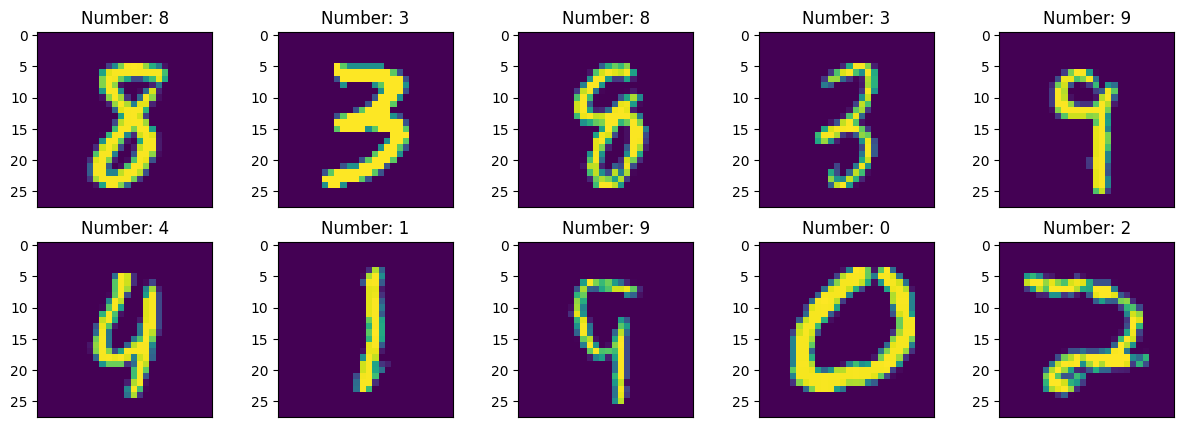

In [10]:
# Display the first 10 images and the labels, and check whether the images are correctly labeled.
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()


In [11]:
# Create a model. The model consists of three fully connected layers. The final output layer uses softmax for classification (10 classes consisting of numbers 0 to 9.)
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(784, 512, activation='relu')  
        self.fc2 = nn.Dense(512, 128, activation='relu')
        self.fc3 = nn.Dense(128, 10, activation=None)
       
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output) 
        output = self.fc3(output)
        return output 


In [17]:
# Create a network, loss function, validation metric, and optimizer, and set related hyperparameters.
lr = 0.0001
num_epoch = 10
momentum = 0.9


net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr) 


In [18]:
# Build a model.
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck)
# Generate a dataset.
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)
# Train the model.
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print("============== Starting Training ==============")
model.train(num_epoch, ds_train,callbacks=[ckpoint_cb,loss_cb,time_cb ],dataset_sink_mode=False)


[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:00:21.185.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:00:21.185.000 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:00:21.185.000 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:00:21.186.000 [mindspore\dataset\core\validator_helpers.py:744] 'Typ

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.5651425719261169
Train epoch time: 2649.137 ms, per step time: 1.413 ms
epoch: 2 step: 1875, loss is 0.26762065291404724
Train epoch time: 2972.767 ms, per step time: 1.585 ms
epoch: 3 step: 1875, loss is 0.2144731879234314
Train epoch time: 3124.673 ms, per step time: 1.666 ms
epoch: 4 step: 1875, loss is 0.2040245085954666
Train epoch time: 3255.371 ms, per step time: 1.736 ms
epoch: 5 step: 1875, loss is 0.16310636699199677
Train epoch time: 3350.817 ms, per step time: 1.787 ms
epoch: 6 step: 1875, loss is 0.0760766863822937
Train epoch time: 3392.986 ms, per step time: 1.810 ms
epoch: 7 step: 1875, loss is 0.015100875869393349
Train epoch time: 3843.970 ms, per step time: 2.050 ms
epoch: 8 step: 1875, loss is 0.05136743187904358
Train epoch time: 4264.298 ms, per step time: 2.274 ms
epoch: 9 step: 1875, loss is 0.015584906563162804
Train epoch time: 4008.469 ms, per step time: 2.138 ms
epoch: 10 step: 18

In [19]:
# Use the test set to validate the model and print the overall accuracy.
metrics=model.eval(ds_eval)
print(metrics)


{'Accuracy': 0.9789663461538461}
